### Load library

In [1]:
#visualization

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageDraw
import PIL.ImageEnhance
import PIL.ImageOps

import seaborn as sns

#python

from typing import Callable, Dict, Tuple
import json
import os

import time
from datetime import datetime

from IPython.display import clear_output
from tqdm import tqdm,notebook

import random

import pickle

import warnings

warnings.filterwarnings('ignore')

#sklearn

from sklearn.metrics import f1_score

#pandas,numpy

import pandas as pd
import numpy as np


#baseline
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('/opt/ml/code/src/'))))

from src.utils.common import get_label_counts,read_yaml
from src.model import Model
from src.dataloader import create_dataloader

from src.loss import CustomCriterion
from src.trainer import TorchTrainer
from src.utils.torch_utils import save_model

from src.utils.inference_utils import run_model

#pytorch

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F


## fix seed

In [3]:
#torch seed
torch.manual_seed(30)
torch.cuda.manual_seed(30)

#numpy seed
np.random.seed(30)

#python seed
random.seed(30)

## load dataset


In [155]:
# define data path

data_path = 'input/data'
train_path = os.path.join(data_path, "train")
val_path = os.path.join(data_path, "val")

In [117]:
#define transform

img_size = 96

transform = transforms.Compose([ transforms.Resize((img_size, img_size)),transforms.ToTensor()])


In [159]:
#define dataset

train_dataset = ImageFolder(root=train_path, transform = transform)
valid_dataset = ImageFolder(root=val_path, transform = transform)

In [119]:
train_dataset[0][0]

tensor([[[0.0784, 0.0706, 0.0471,  ..., 0.0784, 0.0824, 0.0941],
         [0.0667, 0.0667, 0.0431,  ..., 0.0706, 0.0824, 0.0980],
         [0.0784, 0.0588, 0.0471,  ..., 0.0706, 0.0784, 0.0980],
         ...,
         [0.0863, 0.1216, 0.0824,  ..., 0.1725, 0.2039, 0.2275],
         [0.0902, 0.1137, 0.0980,  ..., 0.1765, 0.1804, 0.2118],
         [0.1020, 0.0941, 0.1059,  ..., 0.1765, 0.1765, 0.1922]],

        [[0.0784, 0.0706, 0.0471,  ..., 0.3059, 0.3098, 0.3216],
         [0.0667, 0.0667, 0.0431,  ..., 0.2980, 0.3098, 0.3255],
         [0.0784, 0.0588, 0.0471,  ..., 0.2980, 0.3098, 0.3294],
         ...,
         [0.0863, 0.1255, 0.0941,  ..., 0.1569, 0.1725, 0.1882],
         [0.0902, 0.1176, 0.1059,  ..., 0.1608, 0.1490, 0.1725],
         [0.1020, 0.0980, 0.1137,  ..., 0.1569, 0.1451, 0.1529]],

        [[0.0863, 0.0784, 0.0549,  ..., 0.7294, 0.7333, 0.7451],
         [0.0745, 0.0745, 0.0510,  ..., 0.7216, 0.7333, 0.7490],
         [0.0863, 0.0667, 0.0549,  ..., 0.7216, 0.7333, 0.

## oversampling dataset

In [ ]:
data_config = read_yaml(cfg="exp/850_475000p_96size/data.yml")
data_config = read_yaml(cfg=data_config)

data_config['AUG_TRAIN_PARAMS']['n_select']=3

transform_train = getattr(
        __import__("src.augmentation.policies", fromlist=[""]),
        data_config['AUG_TRAIN'],
    )(dataset=data_config['DATASET'], img_size=96, **data_config['AUG_TRAIN_PARAMS'])

train_dataset = ImageFolder(root=train_path, transform = transform_train)

In [120]:
new_data_list = []
data_list1 = []
data_list2 = []
data_list3 = []
data_list4 = []
data_list5 = []
data_list6 = []
data_list7 = []
data_list8 = []

for data,label in notebook.tqdm(train_dataset):
    if label == 0:
        new_data_list.append((data,label))
    elif label == 1:
        data_list1.append((data,label))
    elif label == 2:
        data_list2.append((data,label))
    elif label == 3:
        data_list3.append((data,label))
    elif label == 4:
        data_list4.append((data,label))
    elif label == 5:
        data_list5.append((data,label))
    elif label == 6:
        data_list6.append((data,label))
    elif label == 7:
        data_list7.append((data,label))
    elif label == 8:
        data_list8.append((data,label))

In [121]:
data_list1 = random.sample(data_list1,261)
data_list2 = random.sample(data_list2,261)
data_list3 = random.sample(data_list3,261)
data_list4 = random.sample(data_list4,261)
data_list5 = random.sample(data_list5,261)
data_list6 = random.sample(data_list6,261)
data_list7 = random.sample(data_list7,261)
data_list8 = random.sample(data_list8,261)

In [122]:
data_list.extend(new_data_list)
data_list.extend(data_list1)
data_list.extend(data_list2)
data_list.extend(data_list3)
data_list.extend(data_list4)
data_list.extend(data_list5)
data_list.extend(data_list6)
data_list.extend(data_list7)
data_list.extend(data_list8)

In [123]:
len(data_list)

28188

In [126]:
#save data list

with open('oversampling_data_list.pkl', 'wb') as f:
    pickle.dump(data_list, f)

## concatenate train, valid set

In [160]:
data_list = []

for data,label in notebook.tqdm(train_dataset):
    data_list.append((data,label))
    
for data,label in notebook.tqdm(valid_dataset):
    data_list.append((data,label))

In [174]:
with open('train_valid_data_list_850.pkl', 'wb') as f:
    pickle.dump(data_list, f)

In [14]:
with open('train_valid_data_list_850.pkl', 'rb') as f:
    data_list = pickle.load(f)

In [64]:
train_loader = DataLoader(
        dataset=train_dataset,
        shuffle=True,
    batch_size=32
    )

In [13]:
#define class label

class_label = {'Battery': 0,
 'Clothing': 1,
 'Glass': 2,
 'Metal': 3,
 'Paper': 4,
 'Paperpack': 5,
 'Plastic': 6,
 'Plasticbag': 7,
 'Styrofoam': 8}

In [14]:
class_label_inverse = {}

for key,value in class_label.items():
    class_label_inverse[value] = key

## show image

In [36]:
img = train_dataset[0][0].numpy() 
img = np.transpose(img, (1, 2, 0))

(<matplotlib.image.AxesImage at 0x7fe3069f0c70>, 'Battery')

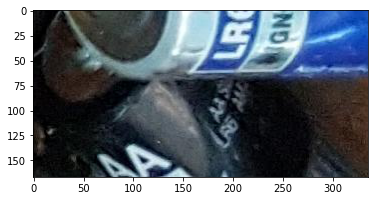

In [38]:
plt.imshow(img) , class_label_inverse[train_dataset[0][1]]

In [109]:
#define show function

def check_image(img,label):
    
    #img = img.numpy()
    #img = np.transpose(img,(1,2,0))
    #img = Equalize(img)
    img = img[0].numpy()
    img = np.transpose(img,(1,2,0))
    label = label.item()
    
    fig = plt.figure()
    plt.title(class_label_inverse[label])
    plt.imshow(img)
    plt.show()

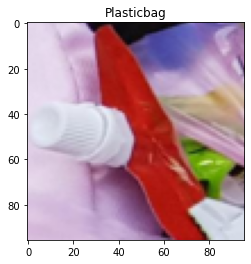

KeyboardInterrupt: 

In [151]:
for img,label in train_loader:
    
    check_image(img,label)
    
    time.sleep(1)
    clear_output(wait=True)

## mixup & cutmix data

In [9]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [36]:
def mixup_data(x, y, alpha=1.0, use_cuda=False):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [53]:
def CutMix(input,target,cutmix_prob,beta=1.0):
    r = np.random.rand(1)
    if beta > 0 and r < cutmix_prob:
        lam = np.random.beta(beta, beta)
        rand_index = torch.randperm(input.size()[0]).cuda()
        target_a = target
        target_b = target[rand_index]
        bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
        input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
        target_a = torch.nn.functional.one_hot(target_a, num_classes=18)
        target_a = target_a.float()
        target_b = torch.nn.functional.one_hot(target_b, num_classes=18)
        target_b = target_b.float()
        label = lam * target_a + (1.0-lam) * target_b
        return input,label
    else:
        return input,target

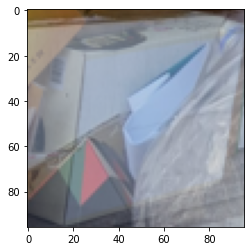

In [66]:
#show mixup image

for img,label in train_loader:
    
    img,target_a,target_b,lam = mixup_data(img,label,alpha=1.0)
    
    img = img[0].numpy()
    img = np.transpose(img,(1,2,0))
    
    plt.imshow(img)
    
    break
    

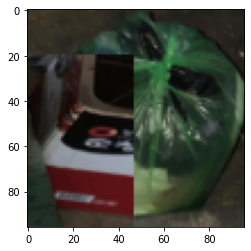

In [70]:
#show cutmix image

for img,label in train_loader:
    
    img,label = CutMix(img,label,cutmix_prob=0.8)
    
    img = img[0].numpy()
    img = np.transpose(img,(1,2,0))
    
    plt.imshow(img)
    
    break

## categorical distribution

In [82]:
train_distribution = get_label_counts(train_path)
valid_distribution = get_label_counts(val_path)

In [83]:
train_distribution

[261, 676, 1169, 1669, 6895, 1458, 3793, 6970, 1560]

In [84]:
valid_distribution

[87, 225, 389, 556, 2298, 486, 1264, 2323, 520]

In [176]:
df_train = pd.DataFrame(index = list(class_label.keys()), data = train_distribution, columns=['values'])

In [177]:
df_train

,values
Battery,261
Clothing,676
Glass,1169
Metal,1669
Paper,6895
Paperpack,1458
Plastic,3793
Plasticbag,6970
Styrofoam,1560


In [110]:
df_valid =  pd.DataFrame(index = list(class_label.keys()), data = valid_distribution, columns=['values'])

<AxesSubplot:title={'center':'Train distribution'}, xlabel='values'>

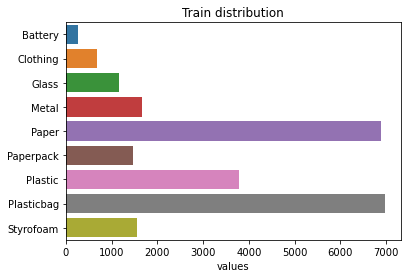

In [178]:
# visualizing true train distribution

plt.title('Train distribution')
sns.barplot(y = df_train.index, x=df_train['values'])

<AxesSubplot:title={'center':'Valid distribution'}, xlabel='values'>

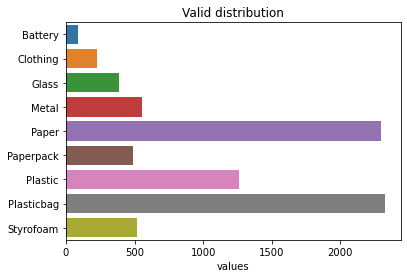

In [111]:
#visualizing true valid distribution

plt.title('Valid distribution')
sns.barplot(y = df_valid.index, x=df_valid['values'])

## check simple inference

In [407]:
#load base model

model_config = read_yaml(cfg="exp/0.5177_100epoch_1120/model.yml")
data_config = read_yaml(cfg="exp/0.5177_100epoch_1120/data.yml")

model_config = read_yaml(cfg=model_config)
data_config = read_yaml(cfg=data_config)

In [408]:
model_instance = Model(model_config, verbose=True)

idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   3 |        816 |          DWConv | [16, 3, 2, None, 'ReLU'] |            3           16
  1 |   1 |      2,016 | InvertedResidualv2 |           [32, 2, 2] |           16           32
  2 |   4 |      2,288 | InvertedResidualv2 |           [16, 1, 2] |           32           16
  3 |   5 |      7,360 | InvertedResidualv2 |           [16, 2, 2] |           16           16
  4 |   2 |    240,656 | InvertedResidualv3 | [5, 3.5, 128, 1, 1, 2] |           16          128
  5 |   1 |     83,200 |            Conv |          [640, 1, 1] |          128          640
  6 |   1 |          0 |   GlobalAvgPool |                   [] |          640          640
  7 |   1 |      5,778 |       FixedConv | [9, 1, 1, None, 1, None] |          640            9
Model Summary: 161 layers, 342,114 parameters, 342,1

In [409]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [410]:
model_path = 'exp/0.533_1120_boosting/best.pt'

if os.path.isfile(model_path):
    model_instance.model.load_state_dict(torch.load(model_path, map_location=device))

In [411]:
data_config['BATCH_SIZE']=1
train_dl, val_dl, test_dl = create_dataloader(data_config)

In [413]:
model_instance.model = model_instance.model.to('cpu')

In [414]:
#inference true train and false train

model_instance.model.eval()

true_list = []
false_list = []

with torch.no_grad():
    for i,(data, target) in notebook.tqdm(enumerate(train_dl)):
        data, target = data.to('cpu'), target.to('cpu')
        output = model_instance.model(data)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if pred == target:
            
            true_list.append((data,target))
        
        else:
            false_list.append((data,target,pred))
            
        

In [136]:
#inference true valid and false valid

model_instance.model.eval()

true_val_list = []
false_val_list = []

with torch.no_grad():
    for i,(data, target) in notebook.tqdm(enumerate(val_dl)):
        data, target = data.to('cpu'), target.to('cpu')
        output = model_instance.model(data)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if pred == target:
            
            true_val_list.append((data,target))
        
        else:
            false_val_list.append((data,target,pred))

In [134]:
#save data list
with open('true_list_1120_0.5120.pkl', 'wb') as f:
    pickle.dump(true_list, f)
    
with open('true_val_list_1120_0.5120.pkl', 'wb') as f:
    pickle.dump(true_val_list, f)
    
with open('false_list_1120_0.5120.pkl', 'wb') as f:
    pickle.dump(false_list, f)

with open('false_val_list_1120_0.5120.pkl', 'wb') as f:
    pickle.dump(false_val_list, f)
    

In [417]:
#load data list

with open('true_list_1120_0.5120.pkl', 'rb') as f:
    true_list = pickle.load(f)

with open('false_list_1120_0.5120.pkl', 'rb') as f:
    false_list = pickle.load(f)

In [155]:
#check false inference image

for img,label,pred in false_list:
    
    check_image(img,label)
    print(class_label_inverse[pred.item()])
    
    time.sleep(2)
    clear_output(wait=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

## visualization False prediction

In [162]:
pred_list = []

for img,label,pred in false_list:
    
    pred_list.append(class_label_inverse[pred.item()])

In [172]:
df = pd.DataFrame(data=pred_list,columns=['label'])

In [173]:
df

,label
0,Glass
1,Plastic
2,Plastic
3,Plastic
4,Plastic
...,...
10138,Plasticbag
10139,Plastic
10140,Glass
10141,Paper


<AxesSubplot:title={'center':'False Prediction'}, xlabel='count', ylabel='label'>

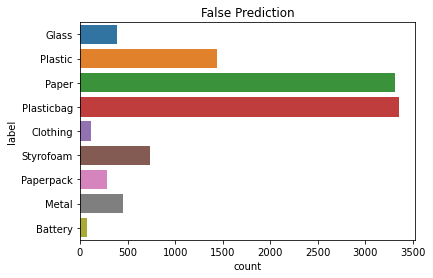

In [175]:
#false inference distribution

plt.title('False Prediction')
sns.countplot(y='label',data=df)

<AxesSubplot:title={'center':'Train distribution'}, xlabel='values'>

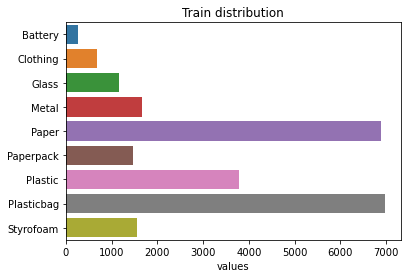

In [179]:
#true distribution

plt.title('Train distribution')
sns.barplot(y = df_train.index, x=df_train['values'])

## visualizing indivisual class prediction

In [235]:
pred_list = []


for img,label,pred in false_list:
    
    if class_label_inverse[label.item()] == 'Battery':
        pred_list.append(class_label_inverse[pred.item()])

In [236]:
df = pd.DataFrame(data=pred_list,columns=['label'])

<AxesSubplot:title={'center':'False Prediction'}, xlabel='count', ylabel='label'>

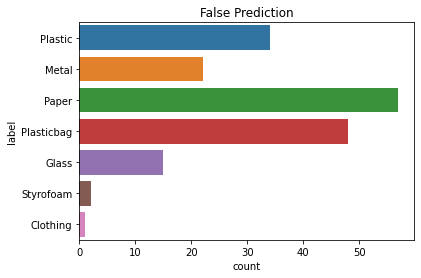

In [237]:
plt.title('False Prediction')
sns.countplot(y='label',data=df)

## visualizae true prediction

In [238]:
pred_list = []

for img,label in true_list:
    
    pred_list.append(class_label_inverse[label.item()])

In [239]:
df = pd.DataFrame(data=pred_list,columns=['label'])

<AxesSubplot:title={'center':'True Prediction'}, xlabel='count', ylabel='label'>

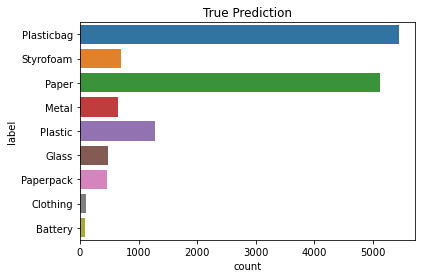

In [240]:
plt.title('True Prediction')
sns.countplot(y='label',data=df)

## visualize false prediction in validation set

In [146]:
pred_list = []

for img,label,pred in false_val_list:
    
    pred_list.append(class_label_inverse[pred.item()])

In [147]:
df = pd.DataFrame(data=pred_list,columns=['label'])

<AxesSubplot:title={'center':'False Prediction'}, xlabel='count', ylabel='label'>

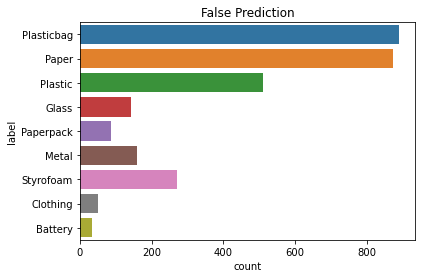

In [148]:
plt.title('False Prediction')
sns.countplot(y='label',data=df)

## downsampling refine dataset

<AxesSubplot:title={'center':'false_distribution'}, xlabel='count', ylabel='label'>

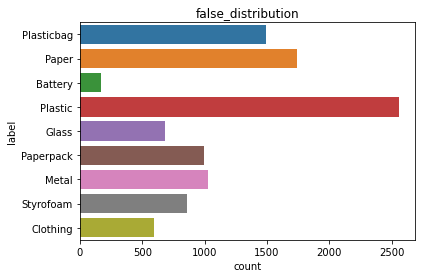

In [151]:
pred_list = []

for img,label,pred in false_list:
    
    pred_list.append(class_label_inverse[label.item()])

df = pd.DataFrame(data=pred_list,columns=['label'])

plt.title('false_distribution')
sns.countplot(y='label',data=df)

In [155]:
list(df['label']).count('Battery')

169

In [156]:
list(df['label']).count('Clothing')

590

In [161]:
list(df['label']).count('Paper')

1742

In [162]:
list(df['label']).count('Plastic')

2556

In [163]:
list(df['label']).count('Plasticbag')

1493

In [157]:
plastic_list = []
plastic_bag_list = []
paper_list = []
new_false_list=[]


for img,label,pred in false_list:
    
    if class_label_inverse[label.item()] == 'Plasticbag':
        plastic_bag_list.append((img,label))
    elif class_label_inverse[label.item()] == 'Plastic':
        plastic_list.append((img,label))
    elif class_label_inverse[label.item()] == 'Paper':
        paper_list.append((img,label))
    else:
        new_false_list.append((img,label))

In [158]:
len(plastic_bag_list)

1493

In [159]:
len(plastic_list)

2556

In [160]:
len(paper_list)

1742

In [164]:
plastic_bag_list = random.sample(plastic_bag_list, 497)

plastic_list = random.sample(plastic_list,511)

paper_list = random.sample(paper_list,580)

In [168]:
new_false_list.extend(plastic_list)
new_false_list.extend(paper_list)
new_false_list.extend(plastic_bag_list)

In [169]:
len(new_false_list)

5909

## boosting false prediction data

In [13]:
#load base model

model_config = read_yaml(cfg="exp/0.5177_100epoch_1120/model.yml")
data_config = read_yaml(cfg="exp/0.5177_100epoch_1120/data.yml")

model_config = read_yaml(cfg=model_config)
data_config = read_yaml(cfg=data_config)

In [14]:
model_instance = Model(model_config, verbose=True)

idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   3 |        816 |          DWConv | [16, 3, 2, None, 'ReLU'] |            3           16
  1 |   1 |      2,016 | InvertedResidualv2 |           [32, 2, 2] |           16           32
  2 |   4 |      2,288 | InvertedResidualv2 |           [16, 1, 2] |           32           16
  3 |   5 |      7,360 | InvertedResidualv2 |           [16, 2, 2] |           16           16
  4 |   2 |    240,656 | InvertedResidualv3 | [5, 3.5, 128, 1, 1, 2] |           16          128
  5 |   1 |     83,200 |            Conv |          [640, 1, 1] |          128          640
  6 |   1 |          0 |   GlobalAvgPool |                   [] |          640          640
  7 |   1 |      5,778 |       FixedConv | [9, 1, 1, None, 1, None] |          640            9
Model Summary: 161 layers, 342,114 parameters, 342,1

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
model_path = 'exp/2021-06-09_19-07-57/best.pt'

if os.path.isfile(model_path):
    model_instance.model.load_state_dict(torch.load(model_path, map_location=device))

In [25]:
train_dl = DataLoader(dataset=true_data_list, shuffle=False, batch_size=1)

In [26]:
#inference false prediction

model_instance.model.eval()

true_list = []
false_list = []

with torch.no_grad():
    for i,(data, target) in notebook.tqdm(enumerate(train_dl)):
        data, target = data.to('cpu'), target.to('cpu')
        output = model_instance.model(data)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if pred == target:
            
            true_list.append((data,target))
        
        else:
            false_list.append((data,target,pred))

## create weight sampler

In [27]:
false_num = len(false_list)

In [30]:
false_num

10082

In [28]:
true_num = len(true_list)

In [31]:
true_num

14369

In [29]:
total_num = false_num + true_num

In [32]:
false_data_list = []

for img,label,pred in false_list:
    
    false_data_list.append((img[0],label[0]))

In [33]:
true_data_list = []

for img,label in true_list:
    
    true_data_list.append((img[0],label[0]))

In [34]:
true_data_list.extend(false_data_list)

In [35]:
weight_tensor = torch.tensor([true_num/total_num , false_num/total_num])

weight_tensor = 1/weight_tensor

In [37]:
true_weight_list = [weight_tensor[0].item()]*true_num

false_weight_list = [weight_tensor[1].item()]*false_num

In [39]:
true_weight_list.extend(false_weight_list)

In [40]:
weight_tensor = torch.tensor(true_weight_list)

In [41]:
weight_tensor

tensor([1.7016, 1.7016, 1.7016,  ..., 2.4252, 2.4252, 2.4252])

In [43]:
weighted_sampler = WeightedRandomSampler(
    weights=weight_tensor,
    num_samples=total_num,
    replacement=False
)

In [70]:
model_config = read_yaml(cfg="exp/850_475000p_96size/model.yml")
data_config = read_yaml(cfg="exp/850_475000p_96size/data.yml")

model_config = read_yaml(cfg=model_config)
data_config = read_yaml(cfg=data_config)

In [128]:
train_dl, val_dl, test_dl = create_dataloader(data_config)

train_dl = DataLoader(dataset=true_data_list, shuffle=False, batch_size=32, sampler=weighted_sampler)

In [71]:
model_instance = Model(model_config, verbose=True)

idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'ReLU'] |            3           16
  1 |   1 |      1,944 | InvertedResidualv3 | [3, 1.2, 32, 1, 0, 2] |           16           32
  2 |   5 |        960 |          DWConv | [64, 1, 2, None, 'ReLU'] |           32           64
  3 |   3 |      8,640 |          DWConv | [144, 3, 2, None, 'ReLU'] |           64          144
  4 |   4 |    451,680 | InvertedResidualv3 | [5, 3.1, 80, 1, 0, 2] |          144           80
  5 |   1 |     10,496 |            Conv |          [128, 1, 1] |           80          128
  6 |   1 |          0 |   GlobalAvgPool |                   [] |          128          128
  7 |   1 |      1,170 |       FixedConv | [9, 1, 1, None, 1, None] |          128            9
Model Summary: 125 layers, 475,354 parameters,

In [66]:
model_path = 'exp/2021-06-09_19-07-57/best.pt'

if os.path.isfile(model_path):
    model_instance.model.load_state_dict(torch.load(model_path, map_location=device))

In [49]:
log_dir = os.path.join("exp", datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
os.makedirs(log_dir, exist_ok=True)

In [72]:
log_dir = 'exp/850_475000p_96size'

In [133]:
data_config

{'AUG_TEST': 'simple_augment_test',
 'AUG_TRAIN': 'randaugment_train',
 'AUG_TRAIN_PARAMS': {'level': None, 'n_select': 0},
 'BATCH_SIZE': 64,
 'DATASET': 'TACO',
 'DATA_PATH': '/opt/ml/input/data/',
 'EPOCHS': 200,
 'FP16': True,
 'IMG_SIZE': 96,
 'INIT_LR': 0.1,
 'VAL_RATIO': 0.0}

## training baseline

In [75]:
#hyperparameter setting

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_path = os.path.join(data_config["DATA_PATH"], "train")
model_path = os.path.join(log_dir, "best.pt")

# Create optimizer, scheduler, criterion
optimizer = torch.optim.SGD(
    model_instance.model.parameters(), lr=0.1, momentum=0.9
)


scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=data_config["INIT_LR"],
    steps_per_epoch=len(train_dl),
    epochs=1000,
    pct_start=0.05,
)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5], gamma=0.5)

criterion = CustomCriterion(
    samples_per_cls=get_label_counts(train_path)
    if data_config["DATASET"] == "TACO"
    else None,
    device=device,
    #loss_type="weighted"
    #loss_type="customloss"
    #loss_type="label_smoothing"
)


# Amp loss scaler
scaler = (
    torch.cuda.amp.GradScaler() if data_config['FP16'] and device != torch.device("cpu") else None
)

In [25]:
#define test function

@torch.no_grad()
def test(model,test_dataloader):
    """Test model.

    Args:
        test_dataloader: test data loader module which is a iterator that returns (data, labels)

    Returns:
        loss, f1, accuracy
    """

    #n_batch = _get_n_batch_from_dataloader(test_dataloader)

    running_loss = 0.0
    preds = []
    gt = []
    correct = 0
    total = 0

    num_classes = 9
    label_list = [i for i in range(num_classes)]

    pbar = notebook.tqdm(enumerate(test_dataloader), total=len(test_dataloader))
    model.to(device)
    model.eval()
    for batch, (data, labels) in pbar:
        data, labels = data.to(device), labels.to(device)

        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model(data)
        else:
            outputs = model(data)
        outputs = torch.squeeze(outputs)
        running_loss += criterion(outputs, labels).item()

        _, pred = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

        preds += pred.to("cpu").tolist()
        gt += labels.to("cpu").tolist()
        pbar.update()
        pbar.set_description(
            f" Val: {'':5} Loss: {(running_loss / (batch + 1)):.3f}, "
            f"Acc: {(correct / total) * 100:.2f}% "
            f"F1(macro): {f1_score(y_true=gt, y_pred=preds, labels=label_list, average='macro', zero_division=0):.2f}"
        )
    loss = running_loss / len(test_dataloader)
    accuracy = correct / total
    f1 = f1_score(
        y_true=gt, y_pred=preds, labels=label_list, average="macro", zero_division=0
    )
    
    return loss, f1, accuracy

In [78]:
#change half tensor model

model_instance.model = torch.nn.DataParallel(model_instance.model)

In [61]:
#basic training

n_epoch=1000

best_test_acc = -1.0
best_test_f1 = -1.0

num_classes = 9

label_list = [i for i in range(num_classes)]

for epoch in range(n_epoch):
    running_loss, correct, total = 0.0, 0, 0
    preds, gt = [], []
    pbar = notebook.tqdm(enumerate(train_dl), total=len(train_dl))
    model_instance.model.train()
    for batch, (data, labels) in pbar:
        
        data, labels = data.to(device), labels.to(device)

        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model_instance.model(data)
        else:
            outputs = model_instance.model(data)
        outputs = torch.squeeze(outputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        scheduler.step()

        _, pred = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        preds += pred.to("cpu").tolist()
        gt += labels.to("cpu").tolist()

        running_loss += loss.item()
        pbar.update()
        pbar.set_description(
            f"Train: [{epoch + 1:03d}] "
            f"Loss: {(running_loss / (batch + 1)):.3f}, "
            f"Acc: {(correct / total) * 100:.2f}% "
            f"F1(macro): {f1_score(y_true=gt, y_pred=preds, labels=label_list, average='macro', zero_division=0):.2f}"
        )
    pbar.close()

    _, test_f1, test_acc = test(
        model=model_instance.model, test_dataloader=val_dl
    )
    if best_test_f1 > test_f1:
        continue
    best_test_acc = test_acc
    best_test_f1 = test_f1
    print(f"Model saved. Current best test f1: {best_test_f1:.3f}")
    save_model(
        model=model_instance.model,
        path=model_path,
        data=data,
        device=device,
    )



KeyboardInterrupt: 

## mixup training

In [79]:
best_test_acc = -1.0
best_test_f1 = -1.0

num_classes = 9

label_list = [i for i in range(num_classes)]

for epoch in range(n_epoch):
    running_loss, correct, total = 0.0, 0, 0
    preds, gt = [], []
    pbar = notebook.tqdm(enumerate(train_dl), total=len(train_dl))
    model_instance.model.train()
    for batch, (data, labels) in pbar:
        
        data,label_a,label_b,lam = mixup_data(data,labels,alpha=1.0)
        
        data, labels, label_a, label_b = data.to(device), labels.to(device), label_a.to(device), label_b.to(device)
        

        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model_instance.model(data)
        else:
            outputs = model_instance.model(data)
        outputs = torch.squeeze(outputs)
        #loss = criterion(outputs, labels)
        loss = criterion(outputs, label_a) * lam + criterion(outputs, label_b)* (1-lam)

        optimizer.zero_grad()

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        scheduler.step()

        _, pred = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        preds += pred.to("cpu").tolist()
        gt += labels.to("cpu").tolist()

        running_loss += loss.item()
        pbar.update()
        pbar.set_description(
            f"Train: [{epoch + 1:03d}] "
            f"Loss: {(running_loss / (batch + 1)):.3f}, "
            f"Acc: {(correct / total) * 100:.2f}% "
            f"F1(macro): {f1_score(y_true=gt, y_pred=preds, labels=label_list, average='macro', zero_division=0):.2f}"
        )
    pbar.close()

    _, test_f1, test_acc = test(
        model=model_instance.model, test_dataloader=val_dl
    )
    if best_test_f1 > test_f1:
        continue
    best_test_acc = test_acc
    best_test_f1 = test_f1
    print(f"Model saved. Current best test f1: {best_test_f1:.3f}")
    save_model(
        model=model_instance.model,
        path=model_path,
        data=data,
        device=device,
    )

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f06e85b30d0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f06e85b30d0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f06e85b30d0>Traceback (most recent call last):
  File "/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()

  File "/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
Traceback (most recent call last):
  File "/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    Traceback (most recent call last):
Exception ignored in:     w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)self._shutdown_workers()  File "/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x

AssertionError
:   File "/miniconda/lib/python3.8/multiprocessing/process.py", line 147, in join
    
self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/miniconda/lib/python3.8/multiprocessing/process.py", line 147, in join

AssertionError    :   File "/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
can only join a child processassert self._parent_pid == os.getpid(), 'can only join a child process'  File "/miniconda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    can only join a child process

    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)AssertionErrorw.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)

  File "/miniconda/lib/python3.8/multiprocessing/process.py", line 147, in join

:       File "/miniconda/lib/python3.8/multiprocessing/process.py", line 147, in join
assert self._parent_pid == os.getpid(), 'can only join a chil

KeyboardInterrupt: 

## undersampling trainset

In [215]:
len(true_list)

14339

In [216]:
len(false_list)

10112

In [217]:
plastic_list = []
plastic_bag_list = []
paper_list = []
new_false_list=[]


for img,label,pred in false_list:
    
    if class_label_inverse[label.item()] == 'Plasticbag':
        plastic_bag_list.append((img,label))
    elif class_label_inverse[label.item()] == 'Plastic':
        plastic_list.append((img,label))
    elif class_label_inverse[label.item()] == 'Paper':
        paper_list.append((img,label))
    else:
        new_false_list.append((img,label))

In [218]:
for img,label in true_list:
    
    if class_label_inverse[label.item()] == 'Plasticbag':
        plastic_bag_list.append((img,label))
    elif class_label_inverse[label.item()] == 'Plastic':
        plastic_list.append((img,label))
    elif class_label_inverse[label.item()] == 'Paper':
        paper_list.append((img,label))
    else:
        new_false_list.append((img,label))

In [219]:
len(plastic_bag_list)

6970

In [220]:
len(plastic_list)

3793

In [221]:
len(paper_list)

6895

In [222]:
plastic_bag_list = random.sample(plastic_bag_list,1743)

In [223]:
plastic_list = random.sample(plastic_list,1264)

In [224]:
paper_list = random.sample(paper_list,1723)

In [225]:
new_false_list.extend(plastic_list)
new_false_list.extend(paper_list)
new_false_list.extend(plastic_bag_list)

## inference

In [48]:
#imagefolder function

CLASSES = ['Battery', 'Clothing', 'Glass', 'Metal', 'Paper', 'Paperpack', 'Plastic', 'Plasticbag', 'Styrofoam']

class CustomImageFolder(ImageFolder):
    """ImageFolder with filename."""

    def __getitem__(self, index):
        img_gt = super(CustomImageFolder, self).__getitem__(index)
        fdir = self.imgs[index][0]
        fname = fdir.rsplit(os.path.sep, 1)[-1]
        return (img_gt + (fname,))

In [49]:
#prepare dataloader

def get_dataloader(img_root: str, data_config: str) -> DataLoader:
    """Get dataloader.

    Note:
	Don't forget to set normalization.
    """
    # Load yaml
    data_config = read_yaml(data_config)

    transform_test_args = data_config["AUG_TEST_PARAMS"] if data_config.get("AUG_TEST_PARAMS") else None
    # Transformation for test
    transform_test = getattr(
        __import__("src.augmentation.policies", fromlist=[""]),
        data_config["AUG_TEST"],
    )(dataset=data_config["DATASET"], img_size=data_config["IMG_SIZE"])

    dataset = CustomImageFolder(root=img_root, transform=transform_test)
    dataloader = DataLoader(
	dataset=dataset,
	batch_size=1,
	num_workers=8
    )
    return dataloader

In [50]:
@torch.no_grad()
def inference(model, dataloader, dst_path: str):
    result = {}
    model = model.to(device)
    model.eval()
    submission_csv = {}
    for img, _, fname in dataloader:
        img = img.to(device)
        pred, enc_data = run_model(model, img)
        pred = torch.argmax(pred)
        submission_csv[fname[0]] = CLASSES[int(pred.detach())]

    result["macs"] = enc_data
    result["submission"] = submission_csv
    j = json.dumps(result, indent=4)
    save_path = os.path.join(dst_path, 'submission.csv')
    with open(save_path, 'w') as outfile:
        json.dump(result, outfile)

In [51]:
dst='/opt/ml/'
#model_weight = 'exp/850_475000p_96size/best.pt'
#model_config ='exp/850_475000p_96size/model.yml'
data_config = 'exp/850_475000p_96size/data.yml'
img_root = 'input/data/test'

In [53]:
# prepare datalaoder
dataloader = get_dataloader(img_root=img_root, data_config=data_config)

# prepare model
#model_instance = Model(model_config, verbose=True)
#model_instance.model.load_state_dict(torch.load(model_weight, map_location=torch.device('cpu')))

# inference
inference(model_instance.model, dataloader, dst)